# Assignment 2:

In this assignment, you are going to solve three problems: 

1. Improving Nearest Neighbors Retrieval Speed (8 points)
2. Gaussian Naive Bayes (4 points)
3. PCA (3 points)

## 1. Improving Nearest Neighbors Retrieval Speed (8 points)

You are given a dataset of coordinates and information about places around the globe. Explore the dataset. You will be mostly working with 2d vectors which represent longitude and latitude.

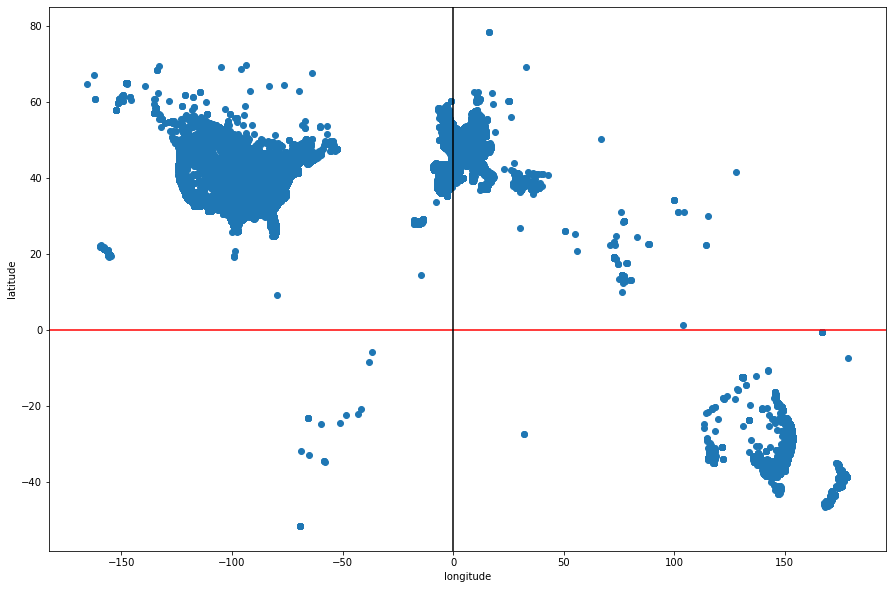

In [69]:
import pickle
import matplotlib.pyplot as plt

with open("poi_sample001.pickle", "rb") as f:
    dataset = pickle.load(f)
    
X = [v[0][0] for v in dataset]
Y = [v[0][1] for v in dataset]

plt.figure(figsize=(15, 10))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.axhline(0, color='red')
plt.axvline(0, color='black')
plt.scatter(X, Y)
plt.show()

### 1.1 Simple NN Search

Implement the simplest form of NN search (exhaustive search).
Your function should: 
1. Calculate the distance between the test point and each dataset point using euclidean distance.
2. Sort the dataset according to calculated distance in ascending order.
3. Return the top K points from the sorted dataset.

You need to implement this from scratch. Don't use library solutions. 
It is okay to use library function for eucliden distance.

In [70]:
from scipy.spatial import distance
import numpy as np

def simple_nns(v, data, k):
    """
    param: v: test point
    param: data: dataset
    param: k: number of nearest neighbors to retrive
    return: list of nearest points from the dataset
    """
    # implement simple NN Search
    dist_point = []
    for point in dataset:
        x_coor = point[0][0] # x coordinate of a point to find distance to
        y_coor = point[0][1] # y coordinate of a point to find distance to
        point_coor = [x_coor, y_coor] # coordinates of a point
        dist = distance.euclidean(v, point_coor) # measure distance from point to point
        dist_point.append([dist, point])

    dist_point = np.array(dist_point) # transforming list to numpy array for applying numpy sort
    dist_point_sorted = dist_point[np.argsort(dist_point[:, 0], kind='mergesort')] # sort
    top_k = dist_point_sorted[:k] # retrieving first k points

    return [point[1] for point in top_k]

Find the first 100 nearest neighbors of Paris. However, we are only interested in shops. Filter out everything that doesn't contain 'Shop' substring in the description and plot the remaining points.

In [71]:
paris = [2.334083, 48.853260]

# find and plot the nearest neighbors according to the above instructions
paris_nn = simple_nns(paris, dataset, 100)
neighbours = simple_nns(paris, dataset, 1000) #for showing purposes

c:\users\valik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


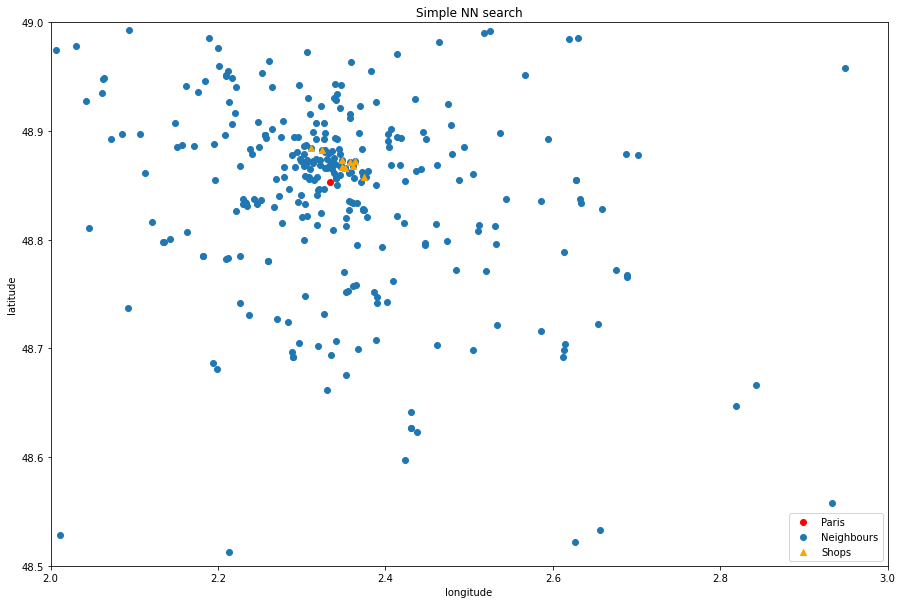

In [72]:
paris_nn_shops = []
for point in paris_nn:
    if "shop" in point[1].lower(): # finding substring "shop" in point description
        paris_nn_shops.append(point)

# coordinates of points with shops near Paris
x_shops = [v[0][0] for v in paris_nn_shops]
y_shops = [v[0][1] for v in paris_nn_shops]

# coordinates of near points
x_neighbour = [v[0][0] for v in neighbours]
y_neighbour = [v[0][1] for v in neighbours]

# plotting configs
plt.figure(figsize=(15, 10))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.title("Simple NN search")
plt.axhline(0, color='red')
plt.axvline(0, color='black')
plt.scatter(paris[0], paris[1], marker='o', color='red', label='Paris')
plt.scatter(x_neighbour, y_neighbour, label='Neighbours')
plt.scatter(x_shops, y_shops, marker='^', color='orange', label='Shops')
plt.legend()

# axes limits are set for better visualization, don't change them
plt.ylim(48.5, 49)
plt.xlim(2,3)
plt.show()

Measure retrieval time of `simple_nns` for every given number of nearest neighbors. Every time select some random point from the dataset. Plot the results.

measuring mean tiem for 10 nns
7.710999202728272
measuring mean tiem for 100 nns
6.177999877929688
measuring mean tiem for 1000 nns
5.082601165771484
measuring mean tiem for 10000 nns
4.905227422714233
measuring mean tiem for 20000 nns
5.018643188476562
measuring mean tiem for 40000 nns
5.067331218719483


c:\users\valik\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


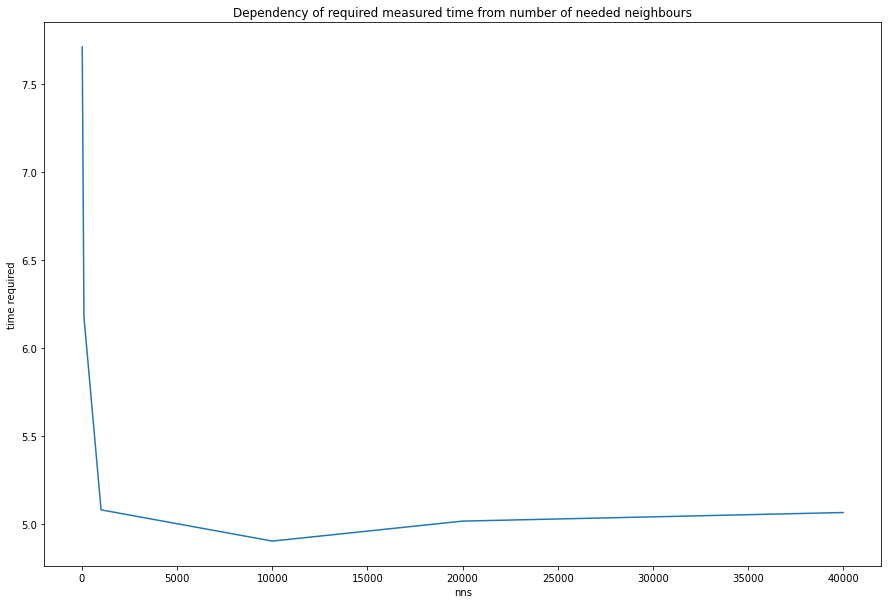

In [87]:
import time
import random as rand

# numbers of nearest neghbors to retrieve
nns = [10, 100, 1000, 10000, 20000, 40000]

# measure retrival time for every value above and save it somewhere 
time_arr = []
for nn in nns:
    times = []
    print("measuring mean tiem for " + str(nn) + " nns", sep=" ")
    for i in range(5):
        # pick random point
        random_point = dataset[rand.randint(0, len(dataset))][0]
        # save start time
        start = time.time()
        # perform search
        neighbours = simple_nns(random_point, dataset, nn)
        # save end point
        end = time.time()
        # compute estimation time
        times.append(end-start)
    # save mean time
    time_arr.append(np.mean(times))
    print(np.mean(times))

# plot the results

# plotting configs
plt.figure(figsize=(15, 10))
a = plt.axes()
a.set_xlabel('nns')
a.set_ylabel('time required')
plt.title("Dependency of required measured time from number of needed neighbours")
plt.plot(nns, time_arr)
plt.show()

What do you observe? Do you see any trends, how can you explain them?

<span style=""> Your answer: </span>
Basically no difference in retirieval time as number of nns grows, because we anyway
go through all dataset and the only complexity that arises is in sorting, which is constant is this case.

### 1.2 Improving NNS

Choose any method you like to speed up NN search, understand it thoroughly and learn how to apply it. Explain the way it works in few sentences and in your own words.

<span style="color:orange"> Your answer: </span>

I chose to use method based on KD-tree. Basically, this method first build the KD-tree from the dataset by taking random (or some specific, depending on implementation) axis,
finding its mean, and splitting samples into two groups: the one with samples in which chosen axis is lower, and second, with samples in which
chosen value of chosen axis is greater. Then do the same procedure for each group, until desired number of cells in the leaves is achieved.
Result is binary tree with search time O(log N). The seacrh space is splitted in cells (leaf).
For finding nearest neighbour for the sample,
we find the sample in the tree,
estimate the distance to other samples in the leaf and take the nearest. We measure distance to nearest leaves, and if it is lower or equal
than distance to found nearest sample, then backtrack to this leaf and try to find nearest point there.

Apply the chosen method on the geographic dataset. Similarly to the above, find the nearest neighbors and plot retrieval times.

In [88]:
# apply the chosen method
from sklearn.neighbors import KDTree

tree = KDTree(np.array([v[0] for v in dataset]))

# v - point coordinates. example [-1, -1]
# dataset - dataset to search from
# k - needed number of neighbours
def improved_nns(v, dataset, k):
    # gain indexes in dataset of k nearest neighbours
    indexes = tree.query(np.expand_dims(np.array(v), axis=0), k= k, return_distance=False)[0].tolist()
    return [dataset[i] for i in indexes]


Find the first 100 nearest neighbors of Paris. However, we are only interested in shops. Filter out everything that doesn't contain 'Shop' substring in the description and plot the remaining points.

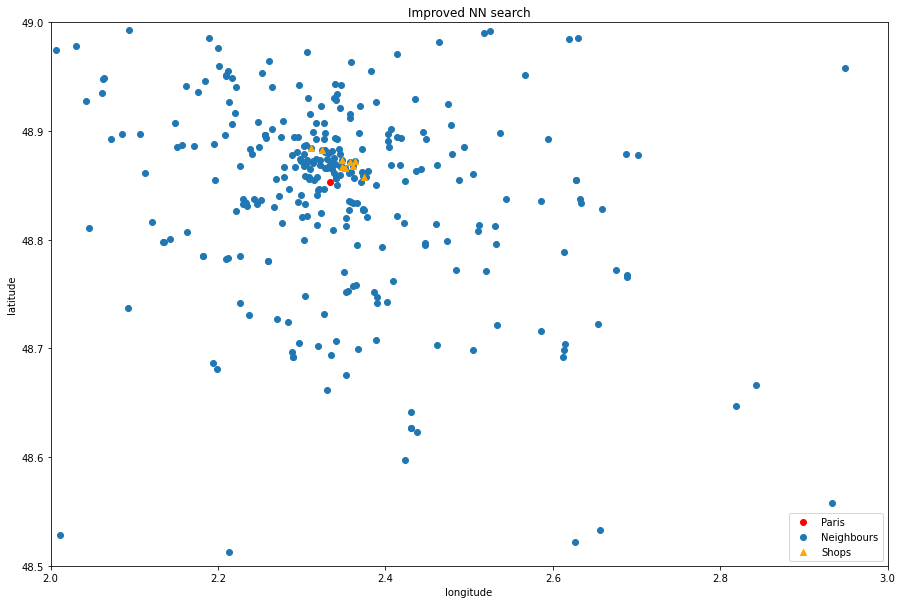

In [89]:
neigh_kd_tree = improved_nns(paris, dataset, 100)
neigh_kd_tree_shops = []
for point in neigh_kd_tree:
    if "shop" in point[1].lower():
        neigh_kd_tree_shops.append(point)

paris = [2.334083, 48.853260]

# find and plot the nearest neighbors according to the above instructions
paris_nn = improved_nns(paris, dataset, 1000)

# neighbours_tree_indexes = tree.query(np.expand_dims(np.array(paris), axis = 0), k=1000, return_distance=False)[0].tolist()
# nn_tree = [dataset[i] for i in neighbours_tree_indexes]

# coordinates of paris k nearest neighbours
x_kd_neigh = [v[0][0] for v in paris_nn]
y_kd_neigh = [v[0][1] for v in paris_nn]

# coordinates of neighbours with shops
x_kd_neigh_shops = [v[0][0] for v in neigh_kd_tree_shops]
y_kd_neigh_shops = [v[0][1] for v in neigh_kd_tree_shops]

# plotting configs
plt.figure(figsize=(15, 10))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.title("Improved NN search")
plt.axhline(0, color='red')
plt.axvline(0, color='black')
plt.scatter(paris[0], paris[1], marker='o', color='red', label='Paris')
plt.scatter(x_kd_neigh, y_kd_neigh, label='Neighbours')
plt.scatter(x_kd_neigh_shops, y_kd_neigh_shops, marker='^', color='orange', label='Shops')
plt.legend()

# axes limits are set for better visualization, don't change them
plt.ylim(48.5, 49)
plt.xlim(2,3)
plt.show()

Measure retrieval time of `simple_nns` for every given number of nearest neighbors. Every time select some random point from the dataset. Plot the results.

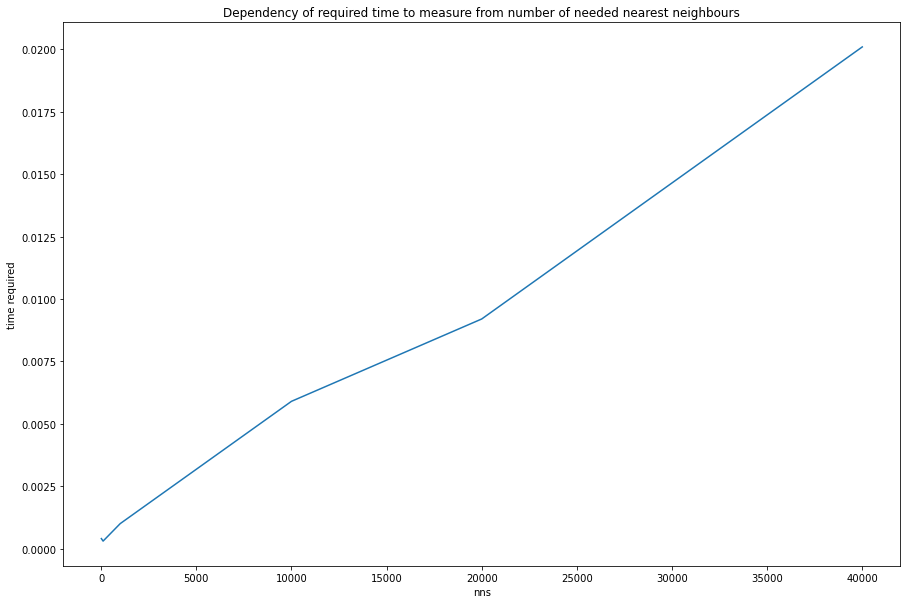

In [90]:
# numbers of nearest neghbors to retrieve
nns = [10, 100, 1000, 10000, 20000, 40000]

# measure retrival time for every value above and save it somewhere 

time_arr_tree = []
for nn in nns:
    times = []
    for i in range(10):
        random_point = dataset[rand.randint(0, len(dataset))][0]
        start = time.time()
        neighbours = improved_nns(random_point, dataset, nn)
        end = time.time()
        times.append(end-start)
    time_arr_tree.append(np.mean(times))

# plot the results

# plot configs
plt.figure(figsize=(15, 10))
a = plt.axes()
a.set_xlabel('nns')
a.set_ylabel('time required')
plt.title("Dependency of required time to measure from number of needed nearest neighbours")
plt.plot(nns, time_arr_tree)
plt.show()
# plot the results



What do you observe? Do you see any trends, how can you explain them?

<span style="color:orange"> Your answer: </span>

Time required for Improved NNS to find nearest neighbours, in compare with Simple NNS,
depends on how many nearest neighbours we want to retrieve, in my keys in
order of O(k log N), where k is number of nearest neighbours we want to find and N is total number of points in dataset.

### 1.3 Comparison

Plot retrieval times together in the same plot. If time difference is big (as it should be), use a logarithmic scale for better visualization. If you don't achieve any time improvements, then you are doing something wrong.

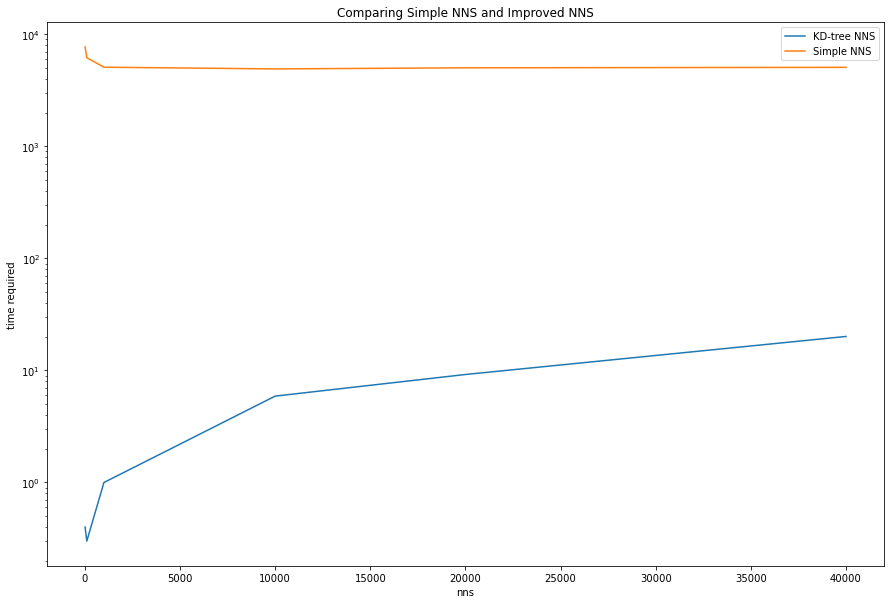

In [91]:
# plot retrieval times together
plt.figure(figsize=(15, 10))
a = plt.axes()
a.set_xlabel('nns')
a.set_ylabel('time required')

time_arr = [i * 1000 for i in time_arr]
time_arr_tree = [i * 1000 for i in time_arr_tree]
plt.yscale("log")
plt.title("Comparing Simple NNS and Improved NNS")
plt.plot(nns, time_arr_tree, label="KD-tree NNS")
plt.plot(nns, time_arr, label="Simple NNS")
plt.legend()
plt.show()

Analyze the results and summarise them here. 

<span style="color:orange"> Your answer: </span>

The chosen methods shown much better performance over Simple NNS, but requires building the KD-first.

## 2. Gaussian Naive Bayes (4 points)

Finish the implementation of Gaussian NB.

In [98]:
import math
import numpy as np

class GaussianNB:
    def fit(self, X_train, y_train):
        """
        fit classifier, i.e. calculate needed statistics
        """
        ### START CODE HERE ###
        
        self.prior = {}
        self.means = {}
        self.std = {}

        self.classes = np.unique(y_train) # list of existing classes in y_train
        classes_index = {} # dictionary with pairs {class - indexes of samples belonging to this class}
        subdatasets = {} # dictionary with pairs {class - samples of this class}
        cls, counts = np.unique(y_train, return_counts=True) # count number of samples of each class
        self.class_freq = dict(zip(cls, counts)) # dictionary with pairs {class - number of samples of this class}

        for class_type in self.classes:
            classes_index[class_type] = np.argwhere(y_train==class_type) # find indexes of samples with this class
            subdatasets[class_type] = X_train[classes_index[class_type], :] # add {class - samples of this class}
            self.prior[class_type] = self.class_freq[class_type]/sum(list(self.class_freq.values())) # calculate prior probability for each class

        for class_type in self.classes:
            self.means[class_type] = np.mean(subdatasets[class_type], axis=0)[0] # calculate mean for each class
            self.std[class_type] = np.std(subdatasets[class_type], axis=0)[0] # calc standard deviation for each class
        print("means: ", end= "")
        print(self.means)
        print("standard deviation: ", end="")
        print(self.std)
        print("prior :", end= "")
        print(self.prior)
        ### END CODE HERE ###

    # Calculate the class probability using gaussian distribution
    def calculate_probability(self, x, mean, stdev):
        exponent = math.exp(-(math.pow(x - mean, 2) / (2 * math.pow(stdev, 2))))
        return (1 / (math.sqrt(2 * math.pi) * stdev)) * exponent

    def calculate_class_prob(self, X):
        # add log of prior to class_probability
        self.class_prob = {cls:math.log(self.prior[cls], math.e) for cls in self.classes}
        for cls in self.classes:
            for i in range(len(self.means)):
                # for each attribute add its log of probabity to class probability
                self.class_prob[cls]+=math.log(self.calculate_probability(X[i], self.means[cls][i], self.std[cls][i]), math.e)
        # resulting dictionary of calculated probabiluty for each class
        self.class_prob_result = {cls: math.e**self.class_prob[cls] for cls in self.class_prob}
        return self.class_prob_result

    def predict(self, X_test):
        """
        predict class labels for test data points
        param: test_data: list of data points to be classified
        return: predictions (class labels)
        """
        ### START CODE HERE ###

        # perdiction set
        predictions = []
        # assign class with max probility to each sample
        for x in X_test:
            pred_class = None
            max_prob = np.NINF
            for cls, prob in self.calculate_class_prob(x).items():
                if pred_class is None or prob>max_prob:
                    max_prob = prob
                    pred_class = cls
            predictions.append(pred_class)

        ### END CODE HERE ###
        
        return predictions

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=1)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

# You should get the accuracy score not less than 90%.
print(accuracy_score(y_test, y_pred))

means: {0: array([4.96153846, 3.36666667, 1.46666667, 0.23333333]), 1: array([5.94594595, 2.73243243, 4.22972973, 1.30540541]), 2: array([6.525     , 2.95227273, 5.53409091, 2.02045455])}
standard deviation: {0: array([0.32786441, 0.36114727, 0.15905705, 0.10459527]), 1: array([0.52432432, 0.32636744, 0.46199618, 0.19857049]), 2: array([0.62162726, 0.30338143, 0.55059603, 0.28089107])}
prior :{0: 0.325, 1: 0.30833333333333335, 2: 0.36666666666666664}
0.9333333333333333


## 3. PCA

Apply PCA to the Digits dataset, produce the scree plot for the given data and decide the optimal number of PCs to keep. Calculate and print their total explained variance.

total explained variance 0.9031878934752079


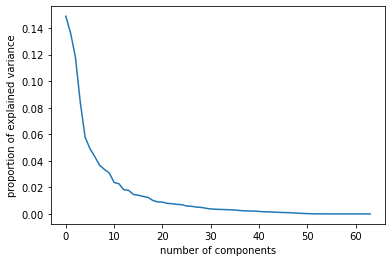

In [100]:
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)

# apply PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import preprocessing

# scale features because features have different variances due to the measure scale,
# for example measured height variance will vary depending whether it measured im meters or centimeters
scaler = preprocessing.StandardScaler().fit_transform(X)
pca = PCA().fit(X)

# make scree plot
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('proportion of explained variance')

# choose the number PCs and calculate and print their total explained variance

pca_resulting = PCA(n_components=21)
pca_resulting.fit(X)
print("total explained variance", end= " ")
print(sum(pca_resulting.explained_variance_ratio_))

Thoroughly justify your choice - this is the main part of the work for this task.

<span style="color:orange"> Your answer: </span>
After looking at graph and applying "elbow method" I decided to check range from 18 to 23 to find optimal number of features to keep.
Calculated total explained variance for each value and decided to keep 21 features